In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2
import datetime

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
tfds.list_builders()

In [ ]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[10%:]'], data_dir='./', as_supervised=True,  with_info=True)# returns `(img, label)` instead of dict(image=, ...))
print('Train %d\nvalid %d\ntest %d'%(ds_info.splits['train[:80%]'].num_examples, 
                                           ds_info.splits['train[80%:90%]'].num_examples, 
                                           ds_info.splits['train[10%:]'].num_examples))

In [25]:
ds_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [26]:
class_num = ds_info.features['label'].num_classes
print("Total flower breed: %d" %(class_num))

Total flower breed: 5


In [29]:
breed_category = []
with open('tf_flowers/3.0.0/label.labels.txt', 'r') as file:
  for line in file:
    breed_name = line.split('-')[0]
    breed_name = breed_name.strip('\n')
    breed_category.append(breed_name)

print("Total category: {}\n{}".format(len(breed_category), breed_category))

Total category: 5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [30]:
tt = ds_train.take(5)

for image, label in tt:  # example is (image, label)
  print(image.shape, label)

(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(4, shape=(), dtype=int64)
(317, 500, 3) tf.Tensor(3, shape=(), dtype=int64)


In [31]:
def show_dataset_img(tf_data, breed_category, num=6):
  img_list = tf_data.take(num)
  fig, axes = plt.subplots(3, 2, figsize=(20,20))
  axes = axes.flatten()
  for (img, label), ax in zip(img_list, axes):
      ax.imshow(img)
      ax.set_title(breed_category[label.numpy()])
      ax.axis('off')
  plt.tight_layout()
  plt.show()

show_dataset_img(ds_train, breed_category=breed_category)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# def normalize_img(image, label):
#   """Normalizes images: `uint8` -> `float32`."""
#   return tf.cast(image, tf.float32) / 255., label

IMAGE_SIZE = 256
def convert(image, label):
  '''
  影像轉換
  '''
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  # label = tf.one_hot(label, class_num)
  return image, label

In [0]:
batch_size = 64

In [0]:
train_batches = (
    ds_train
    # Only train on a subset, so you can quickly see the effect.
    .take(ds_info.splits['train[:80%]'].num_examples)  ## 一次抓取 train 全部資料
    .cache()
    .shuffle(ds_info.splits['train[:80%]'].num_examples)  ## 進行亂數
    # The augmentation is added here.
    .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)  ## 將影像資料進行處理
    .batch(batch_size)    ## 每次執行會輸出 batch size 數量
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

validation_batches = (
    ds_valid
    .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
)

test_batches = (
    ds_test
    # Only train on a subset, so you can quickly see the effect.
    .take(ds_info.splits['train[10%:]'].num_examples)
    .cache()
    .shuffle(ds_info.splits['train[10%:]'].num_examples)
    # The augmentation is added here.
    .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

# Pre-train Model

In [36]:
# Create the base model from the pre-trained model MobileNet V2
IMAGE_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001  ## 學習率
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
## 訓練前測試集評估模型
model.evaluate(test_batches, steps=int(ds_info.splits['train[10%:]'].num_examples / batch_size))

51/51 [==============================] - 9s 184ms/step - loss: 1.8481 - accuracy: 0.2252


[1.84806227684021, 0.22518382966518402]

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=0, mode='auto', patience=5) ## 當大於 10 次沒有增加 val_accuracy 時停止訓練

checkpoint_path = "training_2/best_model.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

pretrain_history = model.fit(train_batches, epochs=100, validation_data=validation_batches, callbacks=[callback, cp_callback])

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.5612 - accuracy: 0.3794
Epoch 00001: saving model to training_2/best_model.ckpt
46/46 [==============================] - 11s 242ms/step - loss: 1.5612 - accuracy: 0.3794 - val_loss: 1.3910 - val_accuracy: 0.4496
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 1.2529 - accuracy: 0.5140
Epoch 00002: saving model to training_2/best_model.ckpt
46/46 [==============================] - 10s 217ms/step - loss: 1.2529 - accuracy: 0.5140 - val_loss: 1.1481 - val_accuracy: 0.5695
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.6155
Epoch 00003: saving model to training_2/best_model.ckpt
46/46 [==============================] - 10s 219ms/step - loss: 1.0395 - accuracy: 0.6155 - val_loss: 0.9719 - val_accuracy: 0.6785
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8853 - accuracy: 0.6993
Epoch 00004: saving model to training_2/best_model.ckpt


# Load Model

In [40]:
model.load_weights('training_2/best_model.ckpt')  ## 載入模型

# Evaluate Model

In [41]:
## 測試集評估模型
model.evaluate(test_batches, steps=int(ds_info.splits['train[10%:]'].num_examples / batch_size))

51/51 [==============================] - 9s 185ms/step - loss: 0.2827 - accuracy: 0.9142


[0.2826635241508484, 0.9142156839370728]

# Confusion Matrix

In [42]:
labels = []
images = []
for image_batch, label_batch in test_batches.take(40):  ## 選多少張來做混淆矩陣  ex: 40 * batch_size
  images.extend(image_batch.numpy())
  labels.extend(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

print(images.shape, labels.shape)

(2560, 256, 256, 3) (2560,)


In [0]:
test_pred_raw = model.predict(images)
test_pred = np.argmax(test_pred_raw, axis=1)  ## 最大值位置

# Calculate the confusion matrix.
cm = confusion_matrix(labels, test_pred, labels=np.arange(len(breed_category)))

Text(0.5, 212.07499999999993, 'Predicted label')

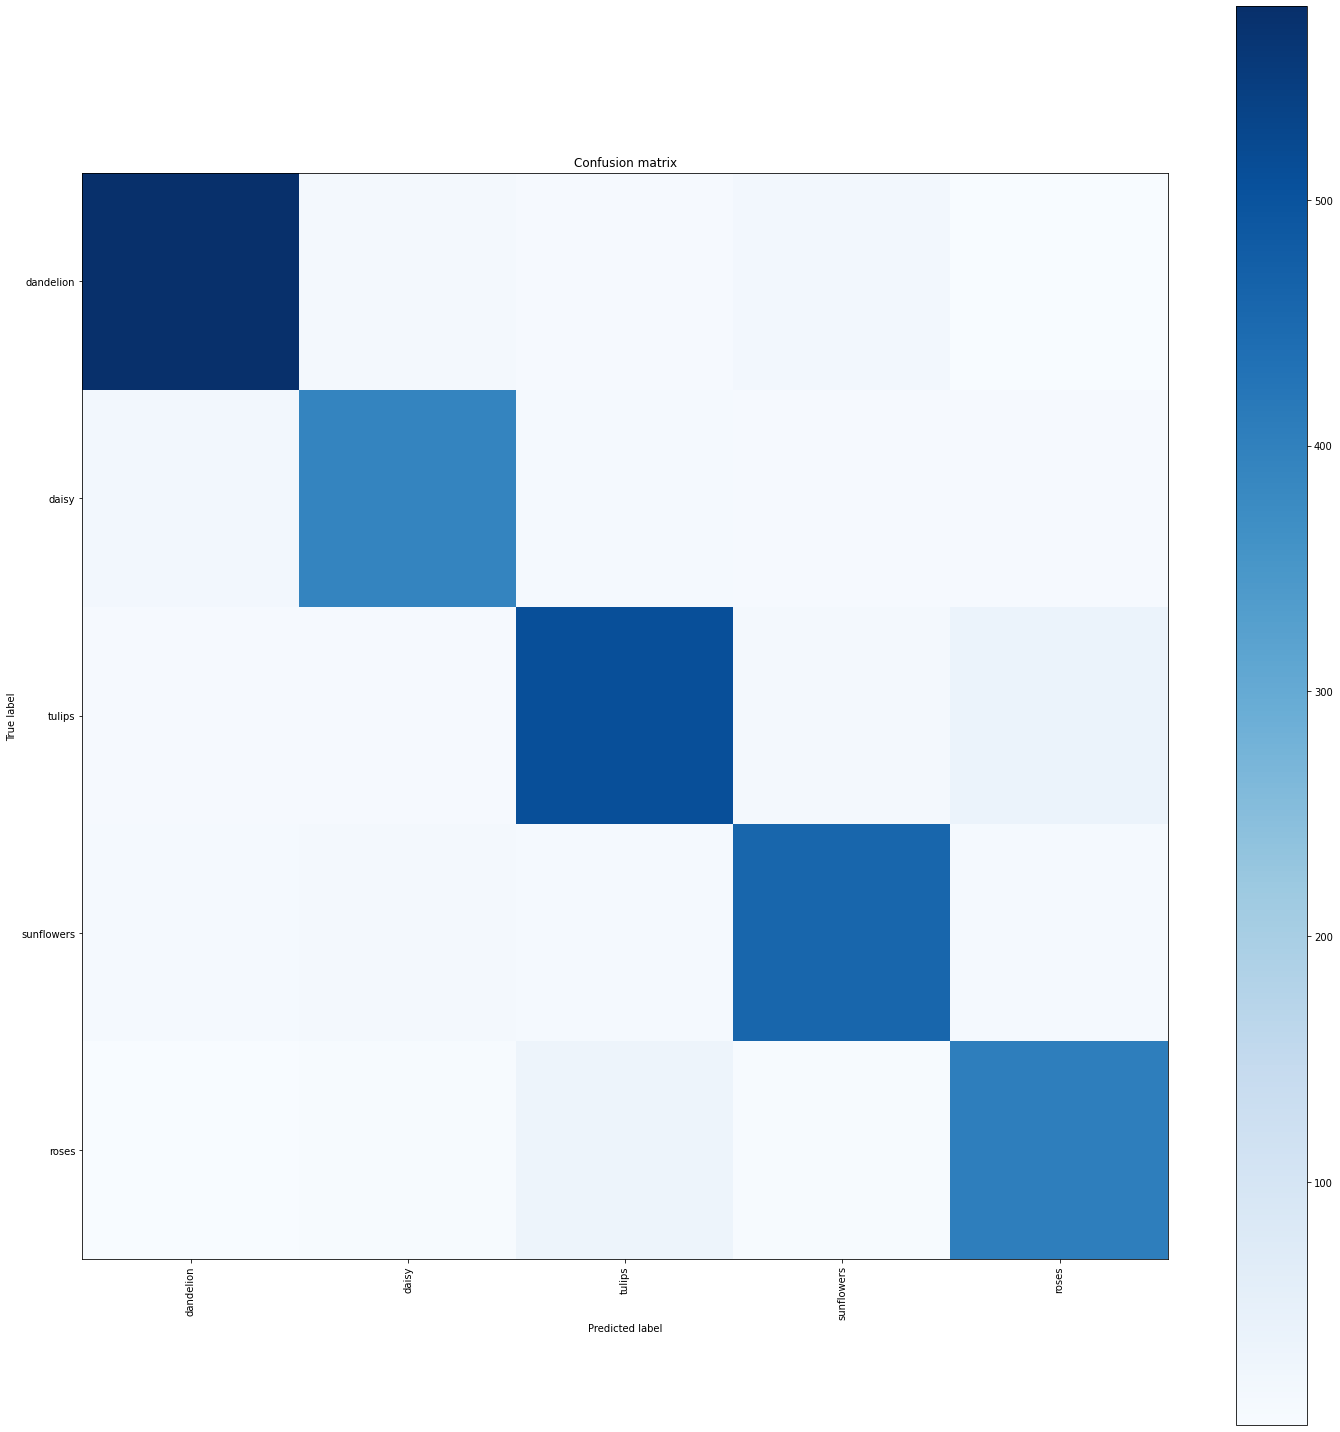

In [44]:
# def plot_confusion_matrix(cm, class_names):
figure = plt.figure(figsize=(20, 20)) ## 圖片大小
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  ## 將 cm 矩陣畫出來
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(breed_category))
plt.xticks(tick_marks, breed_category, rotation=90)
plt.yticks(tick_marks, breed_category)


cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


# threshold = cm.max() / 2.  ## 設定文字顏色閥值
# for i in range(cm.shape[0]):
#   for j in range(cm.shape[1]):
#     color = "white" if cm[i, j] > threshold else "black"  ## 藉由閥值判斷使用白色或黑色字
#     plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# figure.savefig('Confunsion matrix.png', dpi=300)  # 存圖

# Download File

In [0]:
from google.colab import files

files.download('Confunsion matrix.png')